In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px

from vnstock import Vnstock
from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR
from src.plots import foreigner_trading_stock
from src.tcbs_stock_data import TCBSStockData

tcb = TCBSStockData()


def get_price_df(symbol, start, end):
    price_df = tcb.get_stock_data_by_date_range(ticker=symbol, start_date=start, end_date=end)
    if price_df is None or len(price_df) < 10:
        return None
    price_df["time"] = pd.to_datetime(price_df["time"])
    price_df = price_df.sort_values("time").drop_duplicates("time")
    if not set(["close", "volume"]).issubset(price_df.columns):
        return None
    return price_df[["time", "open", "high", "low", "close", "volume"]]


def calculate_sharpe_sortino(df, risk_free_rate=0.0):
    daily_returns = df["close"].pct_change().dropna()
    if len(daily_returns) < 10:
        return np.nan, np.nan
    sharpe = (daily_returns.mean() - risk_free_rate) / daily_returns.std()
    downside_std = daily_returns[daily_returns < 0].std()
    sortino = (
        (daily_returns.mean() - risk_free_rate) / downside_std if downside_std != 0 else np.nan
    )
    return sharpe, sortino


def get_advanced_features(code, start, end):
    try:
        df_foreign = foreigner_trading_stock(code, start, end)
        df_price = get_price_df(code, start, end)
        if (
            df_foreign is None
            or len(df_foreign) < 10
            or "totalRoom" not in df_foreign.columns
            or "currentRoom" not in df_foreign.columns
            or df_price is None
        ):
            return None

        df_foreign["time"] = pd.to_datetime(df_foreign["time"])
        df_foreign = df_foreign.sort_values("time").drop_duplicates("time")
        df_foreign["foreign_holding"] = df_foreign["totalRoom"] - df_foreign["currentRoom"]

        df = pd.merge(df_foreign, df_price, on="time", how="inner").sort_values("time")
        if len(df) < 10:
            return None

        df["foreign_holding_change"] = df["foreign_holding"].diff()
        df["foreign_room_growth"] = df["foreign_holding"].pct_change(5)
        df["foreign_net_buy_3"] = df["foreign_holding_change"].rolling(3).sum()
        df["close_pct_change_5"] = df["close"].pct_change(5)
        df["momentum_5"] = df["close"] - df["close"].shift(5)
        df["volatility_5"] = df["close"].rolling(5).std()
        df["volume_change_3"] = df["volume"].pct_change(3)
        df["vol_MA5"] = df["volume"].rolling(5).mean()

        sharpe, sortino = calculate_sharpe_sortino(df)

        df = df.dropna().reset_index(drop=True)
        last = df.iloc[-1]

        return {
            "code": code,
            "foreign_holding": last["foreign_holding"],
            "foreign_room_growth": last["foreign_room_growth"],
            "sum_foreign_net_buy_3": last["foreign_net_buy_3"],
            "close": last["close"],
            "close_pct_change_5": last["close_pct_change_5"],
            "momentum_5": last["momentum_5"],
            "volatility_5": last["volatility_5"],
            "volume": last["volume"],
            "vol_MA5": last["vol_MA5"],
            "volume_change_3": last["volume_change_3"],
            "sharpe": sharpe,
            "sortino": sortino,
            "price_growth_5": (df["close"].iloc[-1] - df["close"].iloc[-5]) / df["close"].iloc[-5],
            "foreign_holding_growth": (
                df["foreign_holding"].iloc[-1] - df["foreign_holding"].iloc[0]
            )
            / max(1, abs(df["foreign_holding"].iloc[0])),
            "avg_volume_5": df["volume"].rolling(5).mean().iloc[-1],
        }

    except Exception as e:
        print(f"Lỗi với mã {code}: {e}")
        return None


list_code = Vnstock().stock("ACB", source="TCBS").listing.symbols_by_group("HOSE").to_list()
start_date = "2025-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

features_list = []
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {
        executor.submit(get_advanced_features, code, start_date, end_date): code
        for code in list_code
    }
    for future in as_completed(futures):
        res = future.result()
        if isinstance(res, dict):
            features_list.append(res)

df_features = pd.DataFrame(features_list).replace([np.inf, -np.inf], np.nan)
df_features.to_csv(INTERIM_DATA_DIR / "cluster_data.csv")

c:\Users\vinh-nt\AppData\Local\Programs\Python\Python311\Lib\site-packages\vnai\scope\profile.py:562: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-08-26 10:23:06 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-08-26 10:23:06,394 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-08-26 10:23:06 - vnstock.core.utils.client - ERROR - API request failed: HTTPSConnectionPool(host='trading.vietcap.com.vn', port=443): Max retries exceeded with url: /api//price/symbols/getByGroup?group=HOSE (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certif

ConnectionError: API request failed: HTTPSConnectionPool(host='trading.vietcap.com.vn', port=443): Max retries exceeded with url: /api//price/symbols/getByGroup?group=HOSE (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))

In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# --- Chuẩn hóa và phân cụm như cũ ---
df_features = pd.read_csv(INTERIM_DATA_DIR / "cluster_data.csv")

df_features = df_features.dropna(thresh=df_features.shape[1] - 2).fillna(0).reset_index(drop=True)
cols_cluster = [col for col in df_features.columns if col != "code"]
X = StandardScaler().fit_transform(df_features[cols_cluster])

# Chọn best_k bằng silhouette
from sklearn.metrics import silhouette_score

best_k, best_score = 0, -1
for k in range(3, 7):
    labels = KMeans(n_clusters=k, random_state=42, n_init=20).fit_predict(X)
    score = silhouette_score(X, labels)
    if score > best_score:
        best_k, best_score = k, score

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
df_features["cluster"] = kmeans.fit_predict(X).astype(str)

# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_features["pca1"] = X_pca[:, 0]
df_features["pca2"] = X_pca[:, 1]

# Chuẩn hóa các chỉ số đặc trưng trung bình theo từng cluster
cluster_summary = df_features.groupby("cluster").mean(numeric_only=True)
cluster_summary_std = (cluster_summary - cluster_summary.mean()) / cluster_summary.std()

# --- PROFILE VECTOR ĐẶT NHÓM ---
profiles = {
    "Dẫn dắt": {"vol_MA5": 1, "price_growth_5": 0.5, "volatility_5": -0.5},
    "Tiềm năng": {"momentum_5": 1, "sum_foreign_net_buy_3": 1, "sharpe": 0.8},
    "Báo bão": {"volatility_5": 1, "sum_foreign_net_buy_3": -1},
    "Trung lập": {},  # Fallback
}


def compute_similarity_score(cluster_vector, profile_dict):
    keys = list(profile_dict.keys())
    # Chỉ tính similarity nếu đủ key
    if not all(k in cluster_vector.index for k in keys):
        return -1
    profile_vector = np.array([profile_dict[k] for k in keys]).reshape(1, -1)
    cluster_sub = cluster_vector[keys].values.reshape(1, -1)
    return cosine_similarity(cluster_sub, profile_vector)[0][0]


cluster_names = {}
for cluster_id, row in cluster_summary_std.iterrows():
    best_label, best_score = "Trung lập", -1
    for label, profile in profiles.items():
        if not profile:
            continue
        score = compute_similarity_score(row, profile)
        if score > best_score:
            best_score = score
            best_label = label
    cluster_names[str(cluster_id)] = best_label

df_features["cluster_label"] = df_features["cluster"].map(cluster_names)

# --- ĐÁNH DẤU LEADER TĂNG GIÁ ---
df_features["leader"] = ""
for cluster in df_features["cluster"].unique():
    sub = df_features[df_features["cluster"] == cluster]
    top_codes = sub.sort_values("close_pct_change_5", ascending=False).head(2)
    for _, row in top_codes.iterrows():
        df_features.loc[row.name, "leader"] = row["code"]

# --- VẼ BIỂU ĐỒ PCA 2D VỚI PLOTLY ---
import plotly.express as px

cluster_colors = {
    "Báo bão": "#CC2E2E",
    "Trung lập": "#FF9F43",
    "Tiềm năng": "#52C548",
    "Dẫn dắt": "#9B59B6",
}

fig = px.scatter(
    df_features,
    x="pca1",
    y="pca2",
    color="cluster_label",
    color_discrete_map=cluster_colors,
    symbol="code",
    hover_data=["code", "close_pct_change_5", "volume", "foreign_holding"],
    title="Stock Universe Clustering (PCA 2D view) - Interactive",
)

leader_df = df_features[df_features["leader"] != ""]
fig.add_scatter(
    x=leader_df["pca1"],
    y=leader_df["pca2"],
    mode="text",
    text=leader_df["code"],
    textposition="top center",
    textfont=dict(size=13, color="black"),
    showlegend=False,
)

fig.update_traces(marker=dict(size=11, opacity=0.9, line=dict(width=0.5, color="grey")))
fig.update_layout(
    legend_title="Cluster",
    xaxis_title="PCA1",
    yaxis_title="PCA2",
    template="simple_white",
    width=1100,
    height=650,
    hoverlabel=dict(bgcolor="white", font_size=13, font_family="Arial"),
)
fig.show()

# --- XUẤT FILE CSV ---
out_path = PROCESSED_DATA_DIR / "quant_clustered_stock.csv"
df_features.to_csv(out_path, index=False)
print(f"[Done] Xuất file: {out_path}")

[Done] Xuất file: D:\DataLocal\vinh-nt\Desktop\Vincent-Stock-Dashboard-main\data\processed\quant_clustered_stock.csv


Cột loại bỏ do tương quan cao: ['sortino', 'avg_volume_5']
Các feature phân biệt cluster tốt nhất (RFE): ['foreign_holding', 'close_pct_change_5', 'momentum_5', 'volatility_5', 'volume', 'vol_MA5', 'sharpe', 'price_growth_5']


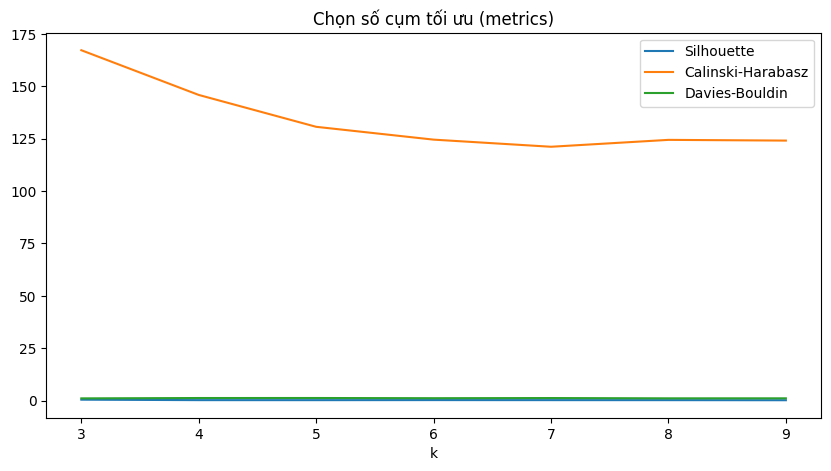

Chọn số cụm tối ưu: 3

>>> Top đặc trưng nổi bật nhất của từng cluster (z-score):

Cluster 0 (321 mã):
  Top 3 chỉ số cao nhất:
foreign_holding   -0.638142
vol_MA5           -0.673111
volume            -0.675088
Name: 0, dtype: float64
  Top 3 chỉ số thấp nhất:
sharpe               -1.152768
close_pct_change_5   -1.034255
momentum_5           -1.015768
Name: 0, dtype: float64

Cluster 1 (29 mã):
  Top 3 chỉ số cao nhất:
foreign_holding    1.152486
vol_MA5            1.149077
volume             1.148834
Name: 1, dtype: float64
  Top 3 chỉ số thấp nhất:
volatility_5     -0.162107
price_growth_5   -0.142445
momentum_5        0.032321
Name: 1, dtype: float64

Cluster 2 (44 mã):
  Top 3 chỉ số cao nhất:
volatility_5      1.071150
price_growth_5    1.063584
momentum_5        0.983448
Name: 2, dtype: float64
  Top 3 chỉ số thấp nhất:
foreign_holding   -0.514345
vol_MA5           -0.475966
volume            -0.473747
Name: 2, dtype: float64

Phân bổ số mã theo nhãn: cluster_label
Báo bão      

[DONE] File xuất tại: quant_clustered_stock.csv

=== Market Share by Cluster ===
               Tổng GTGD (triệu)  Tỷ lệ (%)
cluster_label                              
Báo bão               6566594.19      25.54
Dẫn dắt              14276717.96      55.53
Tiềm năng             4865364.33      18.92


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# ==== 1. Đọc dữ liệu ====
df = pd.read_csv(INTERIM_DATA_DIR / "cluster_data.csv")  # Đổi đường dẫn nếu cần

# ==== 2. Làm sạch ====
df = df.dropna(thresh=df.shape[1] - 2).fillna(0).reset_index(drop=True)
cols_cluster = [col for col in df.columns if col != "code"]

# ==== 3. Loại cột trùng thông tin (corr cao) ====
corr = df[cols_cluster].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
drop_cols = [column for column in upper.columns if any(upper[column] > 0.9)]
cols_cluster_opt = [c for c in cols_cluster if c not in drop_cols]
print("Cột loại bỏ do tương quan cao:", drop_cols)

# ==== 4. Cap outlier (3 sigma rule) ====
for col in cols_cluster_opt:
    m, s = df[col].mean(), df[col].std()
    df[col] = np.clip(df[col], m - 3 * s, m + 3 * s)

# ==== 5. Feature selection với RFE ====
X_full = StandardScaler().fit_transform(df[cols_cluster_opt])
tmp_kmeans = KMeans(n_clusters=3, random_state=42, n_init=20).fit(X_full)
df["tmp_cluster"] = tmp_kmeans.labels_.astype(str)

rfe_selector = RFE(
    RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=8, step=1
)
rfe_selector = rfe_selector.fit(X_full, df["tmp_cluster"])
selected_features = np.array(cols_cluster_opt)[rfe_selector.support_].tolist()
print("Các feature phân biệt cluster tốt nhất (RFE):", selected_features)

# Chỉ dùng các feature này cho clustering
X = StandardScaler().fit_transform(df[selected_features])

# ==== 6. Chọn số cụm tối ưu ====
ks = range(3, 10)
scores = {"k": [], "silhouette": [], "calinski": [], "davies": []}
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    scores["k"].append(k)
    scores["silhouette"].append(silhouette_score(X, labels))
    scores["calinski"].append(calinski_harabasz_score(X, labels))
    scores["davies"].append(davies_bouldin_score(X, labels))
plt.figure(figsize=(10, 5))
plt.plot(scores["k"], scores["silhouette"], label="Silhouette")
plt.plot(scores["k"], scores["calinski"], label="Calinski-Harabasz")
plt.plot(scores["k"], scores["davies"], label="Davies-Bouldin")
plt.legend()
plt.xlabel("k")
plt.title("Chọn số cụm tối ưu (metrics)")
plt.show()

best_k = ks[np.argmax(scores["silhouette"])]
print("Chọn số cụm tối ưu:", best_k)

# ==== 7. Phân cụm KMeans ====
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
df["cluster_kmeans"] = kmeans.fit_predict(X).astype(str)

# ==== 8. Phân tích đặc trưng nổi bật mỗi cluster (auto-profile) ====
cluster_summary = df.groupby("cluster_kmeans")[selected_features].mean()
cluster_summary_std = (cluster_summary - cluster_summary.mean()) / cluster_summary.std()

print("\n>>> Top đặc trưng nổi bật nhất của từng cluster (z-score):")
for cluster_id, row in cluster_summary_std.iterrows():
    print(f"\nCluster {cluster_id} ({len(df[df['cluster_kmeans']==str(cluster_id)])} mã):")
    print("  Top 3 chỉ số cao nhất:")
    print(row.sort_values(ascending=False).head(3))
    print("  Top 3 chỉ số thấp nhất:")
    print(row.sort_values().head(3))

# ==== 9. Profile vector cứng ====
profiles = {
    "Dẫn dắt": {
        "volume": 1,
        "close_pct_change_5": 1,
    },
    "Tiềm năng": {
        "momentum_5": 1,
        "close_pct_change_5": 1,
        "volatility_5": 1,
    },
    "Báo bão": {
        "volatility_5": 1,
        "momentum_5": -1,
        "close_pct_change_5": -1,
    },
    "Bluechip ngoại": {
        "sum_foreign_net_buy_3": 1,
        "foreign_holding": 1,
    },
    "Trung lập": {},
}


def compute_similarity_score(cluster_vector, profile_dict):
    keys = list(profile_dict.keys())
    if not all(k in cluster_vector.index for k in keys):
        return -1
    profile_vector = np.array([profile_dict[k] for k in keys]).reshape(1, -1)
    cluster_sub = cluster_vector[keys].values.reshape(1, -1)
    return cosine_similarity(cluster_sub, profile_vector)[0][0]


cluster_names = {}
for cluster_id, row in cluster_summary_std.iterrows():
    best_label, best_score = "Trung lập", -1
    for label, profile in profiles.items():
        if not profile:
            continue
        score = compute_similarity_score(row, profile)
        if score > best_score:
            best_score = score
            best_label = label
    cluster_names[str(cluster_id)] = best_label

df["cluster_label"] = df["cluster_kmeans"].map(cluster_names)
print("\nPhân bổ số mã theo nhãn:", df["cluster_label"].value_counts())

# ==== 10. Đánh dấu leader tăng giá nhất mỗi cụm ====
df["leader"] = ""
for cluster in df["cluster_kmeans"].unique():
    sub = df[df["cluster_kmeans"] == cluster]
    if "close_pct_change_5" in df.columns:
        top_codes = sub.sort_values("close_pct_change_5", ascending=False).head(2)
        for _, row in top_codes.iterrows():
            df.loc[row.name, "leader"] = row.get("code", "")

# ==== 11. Trực quan hóa PCA 2D ====
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

import plotly.express as px

cluster_colors = {
    "Báo bão": "#CC2E2E",
    "Trung lập": "#FF9F43",
    "Tiềm năng": "#52C548",
    "Dẫn dắt": "#9B59B6",
}
fig = px.scatter(
    df,
    x="pca1",
    y="pca2",
    color="cluster_label",
    color_discrete_map=cluster_colors,
    symbol="code" if "code" in df.columns else None,
    hover_data=(
        ["code", "close_pct_change_5", "volume", "foreign_holding"] if "code" in df.columns else []
    ),
    title="Stock Universe Clustering (PCA 2D view) - Interactive",
)
leader_df = df[df["leader"] != ""]
fig.add_scatter(
    x=leader_df["pca1"],
    y=leader_df["pca2"],
    mode="text",
    text=leader_df["code"] if "code" in df.columns else leader_df.index.astype(str),
    textposition="top center",
    textfont=dict(size=13, color="black"),
    showlegend=False,
)
fig.show()

# ==== 12. Xuất file kết quả ====
df.to_csv(PROCESSED_DATA_DIR / "quant_clustered_stock.csv", index=False)
print("[DONE] File xuất tại: quant_clustered_stock.csv")

# ==== 13. Thống kê market share từng cluster ====
df["value_traded"] = df["close"] * df["volume"]
group_trade_value = df.groupby("cluster_label")["value_traded"].sum()
total_trade_value = group_trade_value.sum()
group_percent = (group_trade_value / total_trade_value * 100).round(2)
market_share = pd.DataFrame(
    {"Tổng GTGD (triệu)": (group_trade_value / 1e6).round(2), "Tỷ lệ (%)": group_percent}
)
print("\n=== Market Share by Cluster ===")
print(market_share)
market_share.to_csv(PROCESSED_DATA_DIR / "market_share_by_cluster.csv")

In [ ]:
pd.to_csv(PROCESSED_DATA_DIR / "quant_clustered_stock.csv", index=False)

Tổng GTGD (triệu)  Tỷ lệ (%)
cluster_label cluster                              
Dẫn dắt       1               1936103.38      41.86
Tiềm năng     0               2665567.06      57.63
              2                 23372.80       0.51

In [4]:
import pandas as pd
import numpy as np
import datetime
from vnstock import Vnstock
from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR
from src.plots import foreigner_trading_stock
from src.tcbs_stock_data import TCBSStockData
from concurrent.futures import ThreadPoolExecutor, as_completed
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

tcb = TCBSStockData()


def get_price_df(symbol, start, end):
    price_df = tcb.get_stock_data_by_date_range(ticker=symbol, start_date=start, end_date=end)
    if price_df is None or len(price_df) < 2:
        return None
    price_df["time"] = pd.to_datetime(price_df["time"])
    price_df = price_df.sort_values("time").drop_duplicates(subset=["time"], keep="last")
    if not set(["close", "volume"]).issubset(set(price_df.columns)):
        return None
    return price_df[["time", "open", "high", "low", "close", "volume"]]


def create_features(code, start, end):
    try:
        df_foreign = foreigner_trading_stock(code, start, end)
        df_price = get_price_df(code, start, end)
        if (
            df_foreign is None
            or df_price is None
            or "totalRoom" not in df_foreign.columns
            or "currentRoom" not in df_foreign.columns
        ):
            return None

        df_foreign["time"] = pd.to_datetime(df_foreign["time"])
        df_foreign = df_foreign.sort_values("time").drop_duplicates(subset=["time"], keep="last")
        df_foreign["foreign_holding"] = df_foreign["totalRoom"] - df_foreign["currentRoom"]
        df = pd.merge(df_foreign, df_price, on="time", how="inner").sort_values("time")
        if len(df) < 21:  # Cần đủ số ngày để tạo rolling
            return None

        # Feature engineering: tạo các chỉ báo kỹ thuật đơn giản
        df["MA5"] = df["close"].rolling(5).mean()
        df["MA20"] = df["close"].rolling(20).mean()
        df["vol_MA20"] = df["volume"].rolling(20).mean()
        df["foreign_MA5"] = df["foreign_holding"].rolling(5).mean()
        df["foreign_net_buy"] = df["foreign_holding"].diff()  # biến động room ngoại
        df["price_change"] = df["close"].pct_change()
        df["volume_change"] = df["volume"].pct_change()
        # Chỉ giữ lại các dòng đã có đủ giá trị
        df = df.dropna().reset_index(drop=True)
        df["symbol"] = code
        return df
    except Exception as e:
        print(f"Lỗi feature {code}: {e}")
        return None


def create_label(df, threshold=0.05, days=5):
    """
    Label = 1 nếu giá close sau 5 ngày tăng >5% so với hiện tại
    """
    close = df["close"].values
    label = []
    for i in range(len(df)):
        future_idx = i + days
        if future_idx < len(df):
            pct_change = (close[future_idx] - close[i]) / close[i]
            label.append(1 if pct_change >= threshold else 0)
        else:
            label.append(np.nan)  # Không label cho những ngày gần cuối
    df["target"] = label
    return df.dropna(subset=["target"]).reset_index(drop=True)


if __name__ == "__main__":
    list_code = Vnstock().stock("ACB", source="TCBS").listing.symbols_by_group("HOSE").to_list()
    start_date = "2024-10-01"  # nên lấy dài ra để có nhiều dữ liệu train
    today = datetime.datetime.now()
    end_date = today.strftime("%Y-%m-%d")

    # 1. Thu thập dữ liệu & tạo features
    dfs = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {
            executor.submit(create_features, code, start_date, end_date): code
            for code in list_code
        }
        for future in as_completed(futures):
            res = future.result()
            if res is not None:
                dfs.append(res)
    if not dfs:
        print("Không lấy được dữ liệu đủ lớn!")
        exit()

    df_all = pd.concat(dfs, ignore_index=True)

    # 2. Gán label dựa trên biến động giá 5 phiên tiếp theo
    dfs_label = []
    for symbol, df_sub in df_all.groupby("symbol"):
        df_labeled = create_label(df_sub)
        dfs_label.append(df_labeled)
    df_all_label = pd.concat(dfs_label, ignore_index=True)

    # 3. Chia dữ liệu train/test, train mô hình ML
    feature_cols = [
        "close",
        "volume",
        "MA5",
        "MA20",
        "vol_MA20",
        "foreign_holding",
        "foreign_MA5",
        "foreign_net_buy",
        "price_change",
        "volume_change",
    ]
    df_all_label = df_all_label.dropna(subset=feature_cols + ["target"])
    X = df_all_label[feature_cols]
    y = df_all_label["target"].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = lgb.LGBMClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Báo cáo đánh giá mô hình:\n")
    print(classification_report(y_test, y_pred, digits=3))

    # 4. Dự báo cho phiên mới nhất của từng mã và xuất kết quả
    latest_rows = df_all_label.groupby("symbol").tail(1)
    latest_X = latest_rows[feature_cols]
    latest_rows["predict_prob"] = model.predict_proba(latest_X)[:, 1]
    latest_rows = latest_rows.sort_values("predict_prob", ascending=False)

    # Chỉ xuất ra những mã có xác suất tăng mạnh cao nhất
    top_result = latest_rows[["symbol", "time", "close", "predict_prob"]].head(20)
    print("\nTop cổ phiếu tiềm năng:")
    print(top_result)

    top_result.to_csv(PROCESSED_DATA_DIR / "ml_top_foreign_buy_stock.csv", index=False)

2025-08-26 10:24:04 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-08-26 10:24:04,214 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-08-26 10:24:04.805 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'ThreadPoolExecutor-1_5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-26 10:24:04.807 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'ThreadPoolExecutor-1_3': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-26 10:24:04.807 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'ThreadPoolExecutor-1_0': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-26 10:24:04.807 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'ThreadPoolExecut

[LightGBM] [Info] Number of positive: 7100, number of negative: 51677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 58777, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120796 -> initscore=-1.984918
[LightGBM] [Info] Start training from score -1.984918
Báo cáo đánh giá mô hình:

              precision    recall  f1-score   support

           0      0.876     0.997     0.932     12851
           1      0.379     0.012     0.023      1844

    accuracy                          0.874     14695
   macro avg      0.627     0.505     0.478     14695
weighted avg      0.813     0.874     0.818     14695


Top cổ phiếu tiềm năng:
         symbol       time    close  predict_prob
22512  FUEABVN

C:\Users\vinh-nt\AppData\Local\Temp\ipykernel_8488\1645917621.py:139: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

from vnstock import Vnstock
from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR
from src.plots import foreigner_trading_stock
from src.tcbs_stock_data import TCBSStockData

tcb = TCBSStockData()


def get_price_df(symbol, start, end):
    price_df = tcb.get_stock_data_by_date_range(ticker=symbol, start_date=start, end_date=end)
    if price_df is None or len(price_df) < 2:
        print(f"[{symbol}] Không có dữ liệu giá/volume")
        return None
    price_df["time"] = pd.to_datetime(price_df["time"])
    price_df = price_df.sort_values("time")
    price_df = price_df.drop_duplicates(subset=["time"], keep="last")
    if not set(["close", "volume"]).issubset(set(price_df.columns)):
        print(f"[{symbol}] Thiếu cột close/volume trong dữ liệu giá")
        return None
    return price_df[["time", "open", "high", "low", "close", "volume"]]


def analyze_advanced(code, start, end):
    try:
        df_foreign = foreigner_trading_stock(code, start, end)
        if (
            df_foreign is None
            or len(df_foreign) < 2
            or "totalRoom" not in df_foreign.columns
            or "currentRoom" not in df_foreign.columns
        ):
            print(f"[{code}] Không đủ dữ liệu foreign room")
            return None
        df_foreign["time"] = pd.to_datetime(df_foreign["time"])
        df_foreign = df_foreign.sort_values("time")
        df_foreign = df_foreign.drop_duplicates(subset=["time"], keep="last")
        df_foreign["foreign_holding"] = df_foreign["totalRoom"] - df_foreign["currentRoom"]
        df_price = get_price_df(code, start, end)
        if df_price is None:
            print(f"[{code}] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá")
            return None
        df = pd.merge(df_foreign, df_price, on="time", how="inner").sort_values("time")
        if len(df) < 2:
            print(f"[{code}] Không có ngày giao dịch trùng giữa nước ngoài và giá")
            return None
        df["MA_5"] = df["foreign_holding"].rolling(window=5, min_periods=1).mean()
        df["vol_MA20"] = df["volume"].rolling(window=20, min_periods=1).mean()
        cnt = 0
        ma = df["MA_5"].values
        close = df["close"].values
        vol = df["volume"].values
        vol_ma20 = df["vol_MA20"].values
        for i in range(len(ma) - 1, 0, -1):
            if (ma[i] > ma[i - 1]) and (close[i] > close[i - 1]) and (vol[i] > vol_ma20[i]):
                cnt += 1
            else:
                break
        return {
            "code": code,
            "consecutive_increase_all": cnt,
            "last_MA": ma[-1] if len(ma) > 0 else None,
            "last_close": close[-1] if len(close) > 0 else None,
            "last_vol": vol[-1] if len(vol) > 0 else None,
        }
    except Exception as e:
        print(f"Lỗi với mã {code}: {e}")
        return None


if __name__ == "__main__":
    list_code = Vnstock().stock("ACB", source="TCBS").listing.symbols_by_group("HOSE").to_list()
    start_date = "2025-04-01"
    today = datetime.datetime.now()
    end_date = today.strftime("%Y-%m-%d")
    results = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {
            executor.submit(analyze_advanced, code, start_date, end_date): code
            for code in list_code
        }
        for future in as_completed(futures):
            res = future.result()
            if isinstance(res, dict) and "consecutive_increase_all" in res:
                results.append(res)

    print(f"Tổng số mã được phân tích thành công: {len(results)}")
    df_result = pd.DataFrame(results)
    if "consecutive_increase_all" in df_result.columns:
        df_result = df_result[df_result["consecutive_increase_all"].notnull()]
        df_result = df_result.sort_values("consecutive_increase_all", ascending=False)
        df_result.to_csv(PROCESSED_DATA_DIR / "top_foreign_buy_with_price_volume.csv", index=False)
    else:
        print("Không có mã nào đủ dữ liệu tiêu chí!")
        print(df_result.head())

2025-08-26 10:25:28 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-08-26 10:25:28,698 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-08-26 10:25:29,025 - tcbs_stock_data - INFO - Lấy dữ liệu AAA từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:29,028 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho AAA từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:29,030 - tcbs_stock_data - INFO - Lấy dữ liệu ABS từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:29,032 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho ABS từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:29,061 - tcbs_stock_data - INFO - Lấy dữ liệu AAT từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:29,063 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho AAT từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:29,066 - tcbs_stock_data - INFO - Lấy dữ liệu ACB từ 2025-04-01 đến 2025-08-26
2025-08-26 10:

[NAF] Không có dữ liệu giá/volume
[NAF] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá


2025-08-26 10:25:47,353 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho MWG: 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:47,354 - tcbs_stock_data - INFO - Lấy được 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:47,355 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-26
2025-08-26 10:25:47,426 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho NAB: 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:47,428 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho NAV: 101 điểm dữ liệu từ 2025-04-01 đến 2025-08-25
2025-08-26 10:25:47,429 - tcbs_stock_data - INFO - Lấy được 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:47,430 - tcbs_stock_data - INFO - Lấy được 101 điểm dữ liệu từ 2025-04-01 đến 2025-08-25
2025-08-26 10:25:47,434 - tcbs_stock_data - WARNING - Lưu ý: Dữ liệu mới nhất đến 2025-08-25 (sớm hơn 2025-08-26 yêu cầu)
2025-08-26 10:25:47,448 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệ

[NHT] Không có dữ liệu giá/volume
[NHT] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá
[NSC] Không có dữ liệu giá/volume
[NSC] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá


2025-08-26 10:25:47,824 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-26
2025-08-26 10:25:47,857 - tcbs_stock_data - INFO - Lấy dữ liệu NVL từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:47,859 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho NVL từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:47,896 - tcbs_stock_data - INFO - Lấy dữ liệu NVT từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:47,896 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho NVT từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:47,911 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-26
2025-08-26 10:25:47,925 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho NKG: 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:47,926 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-26
2025-08-26 10:25:47,927 - tcbs_stock_data - INFO - Lấy được 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:47,985 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho NLG: 1

[SCS] Không có dữ liệu giá/volume
[SCS] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá


2025-08-26 10:25:51,728 - tcbs_stock_data - INFO - Lấy dữ liệu SFI từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:51,728 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho SFI từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:51,746 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho SCR: 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:51,747 - tcbs_stock_data - INFO - Lấy được 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:51,770 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-23
2025-08-26 10:25:51,782 - tcbs_stock_data - INFO - Lấy dữ liệu SGN từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:51,783 - tcbs_stock_data - INFO - Lấy dữ liệu SGR từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:51,784 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho SGN từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:51,785 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho SGR từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:51,797 - tcbs_stock_data - INFO - Lấy dữ liệ

[TIX] Không có dữ liệu giá/volume
[TIX] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá


2025-08-26 10:25:55,775 - tcbs_stock_data - INFO - Lấy được 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:55,814 - tcbs_stock_data - ERROR - Lỗi khi lấy dữ liệu: 429 Client Error: Too Many Requests for url: https://apipubaws.tcbs.com.vn/stock-insight/v2/stock/bars-long-term?ticker=TMP&type=stock&resolution=D&to=1756141200&countBack=5000
2025-08-26 10:25:55,814 - tcbs_stock_data - WARNING - Không có dữ liệu được lấy
2025-08-26 10:25:55,815 - tcbs_stock_data - WARNING - Không có dữ liệu cho TMP từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:55,837 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho TIP: 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:55,838 - tcbs_stock_data - INFO - Lấy được 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:55,845 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-26
2025-08-26 10:25:55,850 - tcbs_stock_data - INFO - Lấy dữ liệu TMT từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:55,851 - tcbs_st

[TMP] Không có dữ liệu giá/volume
[TMP] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá


2025-08-26 10:25:56,004 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho TNH từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,005 - tcbs_stock_data - INFO - Lấy dữ liệu TNC từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,007 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho TNC từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,022 - tcbs_stock_data - INFO - Lấy dữ liệu TNI từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,023 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho TNI từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,049 - tcbs_stock_data - INFO - Lấy dữ liệu TNT từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,049 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho TNT từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,066 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-26
2025-08-26 10:25:56,068 - tcbs_stock_data - ERROR - Lỗi khi lấy dữ liệu: 429 Client Error: Too Many Requests for url: https://apipubaws.tcbs.com.vn/stock-insight/v2/stock/bars-long-term?ticke

[TN1] Không có dữ liệu giá/volume
[TN1] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá
[TNI] Không có dữ liệu giá/volume
[TNI] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá


2025-08-26 10:25:56,252 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho TPC từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,317 - tcbs_stock_data - INFO - Lấy dữ liệu TRC từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,320 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho TMT: 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,321 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho TRC từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,323 - tcbs_stock_data - INFO - Lấy dữ liệu TRA từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,323 - tcbs_stock_data - INFO - Lấy được 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,325 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho TRA từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,424 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho TNH: 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,425 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-26
2025-08-26 10:25:56,426 -

[TSC] Không có dữ liệu giá/volume
[TSC] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá


2025-08-26 10:25:56,827 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho TRC: 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,830 - tcbs_stock_data - INFO - Lấy dữ liệu TVS từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,831 - tcbs_stock_data - INFO - Lấy được 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,831 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho TVS từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,851 - tcbs_stock_data - INFO - Lấy dữ liệu TVB từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,851 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-23
2025-08-26 10:25:56,852 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho TVB từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,935 - tcbs_stock_data - INFO - Lấy dữ liệu TVT từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,936 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho TVT từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:56,951 - tcbs_stock_data - ERROR - Lỗi khi l

[TV2] Không có dữ liệu giá/volume
[TV2] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá


2025-08-26 10:25:57,173 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-26
2025-08-26 10:25:57,185 - tcbs_stock_data - INFO - Lấy dữ liệu VAF từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:57,186 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho VAF từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:57,253 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-23
2025-08-26 10:25:57,266 - tcbs_stock_data - INFO - Lấy dữ liệu VCA từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:57,267 - tcbs_stock_data - INFO - Lấy dữ liệu VAB từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:57,267 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho VCA từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:57,268 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho VAB từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:57,292 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho TVB: 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:57,293 - tcbs_stock_data - INFO - Lấy được 102 điểm dữ liệu t

[VMD] Không có dữ liệu giá/volume
[VMD] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá
[VNG] Không có dữ liệu giá/volume
[VNG] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá


2025-08-26 10:25:59,016 - tcbs_stock_data - INFO - Lấy dữ liệu VOS từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:59,016 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho VOS từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:59,037 - tcbs_stock_data - INFO - Lấy dữ liệu VPD từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:59,039 - tcbs_stock_data - INFO - Lấy dữ liệu VPB từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:59,039 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho VPD từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:59,039 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho VPB từ 2025-04-01 đến 2025-08-26
2025-08-26 10:25:59,091 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-26
2025-08-26 10:25:59,104 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-26
2025-08-26 10:25:59,123 - tcbs_stock_data - INFO - Đã lấy 250 điểm dữ liệu từ 2024-08-23
2025-08-26 10:25:59,147 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho VND: 102 điểm dữ liệu từ 2025-04-01 đến 

[VTB] Không có dữ liệu giá/volume
[VTB] Không đủ dữ liệu giá/volume hoặc lỗi lấy giá


2025-08-26 10:26:00,411 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho VSI: 101 điểm dữ liệu từ 2025-04-01 đến 2025-08-25
2025-08-26 10:26:00,412 - tcbs_stock_data - INFO - Lấy được 101 điểm dữ liệu từ 2025-04-01 đến 2025-08-25
2025-08-26 10:26:00,413 - tcbs_stock_data - WARNING - Lưu ý: Dữ liệu mới nhất đến 2025-08-25 (sớm hơn 2025-08-26 yêu cầu)
2025-08-26 10:26:00,506 - tcbs_stock_data - INFO - Lấy dữ liệu YEG từ 2025-04-01 đến 2025-08-26
2025-08-26 10:26:00,507 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho YEG từ 2025-04-01 đến 2025-08-26
2025-08-26 10:26:00,509 - tcbs_stock_data - INFO - Lấy dữ liệu YBM từ 2025-04-01 đến 2025-08-26
2025-08-26 10:26:00,512 - tcbs_stock_data - INFO - Bắt đầu lấy dữ liệu cho YBM từ 2025-04-01 đến 2025-08-26
2025-08-26 10:26:00,538 - tcbs_stock_data - INFO - Đã hoàn thành lấy dữ liệu cho VTP: 102 điểm dữ liệu từ 2025-04-01 đến 2025-08-26
2025-08-26 10:26:00,540 - tcbs_stock_data - INFO - Lấy được 102 điểm dữ liệu từ 2025-04-01 đến 2025-

Tổng số mã được phân tích thành công: 399


In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from vnstock import Vnstock
from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR
from src.plots import foreigner_trading_stock


def analyze_symbol(code):
    try:
        df = foreigner_trading_stock(code, "2025-01-01", "2025-08-26")
        if len(df) < 2:
            return None
        df = df.sort_values("time")
        if (
            "foreign_holding" not in df.columns
            and "totalRoom" in df.columns
            and "currentRoom" in df.columns
        ):
            df["foreign_holding"] = df["totalRoom"] - df["currentRoom"]
        if "foreign_holding" not in df.columns:
            return None
        df["MA_5"] = df["foreign_holding"].rolling(window=5, min_periods=1).mean()
        ma = df["MA_5"].values
        cnt = 0
        for i in range(len(ma) - 1, 0, -1):
            if ma[i] > ma[i - 1]:
                cnt += 1
            else:
                break
        return {
            "code": code,
            "consecutive_increase_MA": cnt,
            "last_MA": ma[-1] if len(ma) > 0 else None,
            "first_MA": ma[0] if len(ma) > 0 else None,
            "total_increase_MA": (ma[-1] - ma[0]) if len(ma) > 0 else None,
        }
    except Exception as e:
        print(f"Lỗi với mã {code}: {e}")
        return None


# Đọc list mã
list_code = Vnstock().stock("ACB", source="TCBS").listing.symbols_by_group("HOSE").to_list()
results = []

with ThreadPoolExecutor(max_workers=20) as executor:
    futures = {executor.submit(analyze_symbol, code): code for code in list_code}
    for future in as_completed(futures):
        res = future.result()
        if res is not None:
            results.append(res)

df_result = pd.DataFrame(results)
df_result = df_result.sort_values("consecutive_increase_MA", ascending=False)
df_result.to_csv(PROCESSED_DATA_DIR / "consecutive_increase_MA.csv")

2025-08-26 10:27:21 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.
2025-08-26 10:27:21,591 - vnstock.common.data.data_explorer - INFO - TCBS không cung cấp thông tin danh sách. Dữ liệu tự động trả về từ VCI.


In [19]:
import plotly.express as px
import numpy as np

# Đọc file kết quả consecutive_increase_MA.csv
df_consecutive = pd.read_csv(PROCESSED_DATA_DIR / "consecutive_increase_MA.csv")
df_consecutive["pct_increase_MA"] = (
    (df_consecutive["last_MA"] - df_consecutive["first_MA"]) / df_consecutive["first_MA"] * 100
)

# Sắp xếp giảm dần theo số ngày tăng liên tiếp
df_consecutive = df_consecutive.sort_values("consecutive_increase_MA", ascending=False)

# Tạo cột size từ giá trị tuyệt đối của total_increase_MA
df_consecutive["size"] = np.abs(df_consecutive["total_increase_MA"])

# Tạo scatter plot với size biểu thị mức tăng tổng thể
fig = px.scatter(
    df_consecutive.head(30),
    x="code",
    y="consecutive_increase_MA",
    size="size",  # Size của bubble dựa vào giá trị tuyệt đối
    hover_data=["last_MA", "first_MA", "total_increase_MA"],  # Thêm thông tin khi hover
    title="Top 30 cổ phiếu có số ngày tăng MA_5 liên tiếp cao nhất",
    labels={
        "consecutive_increase_MA": "Số ngày tăng liên tiếp MA_5",
        "code": "Mã CK",
        "total_increase_MA": "Mức tăng tổng thể",
    },
)
# Cập nhật layout
fig.update_layout(xaxis_tickangle=-45, showlegend=False, height=600, width=1000)

fig.show()

# Vẽ biểu đồ scatter: X = số ngày tăng liên tiếp, Y = % tăng MA
fig = px.scatter(
    df_consecutive.head(30),
    x="consecutive_increase_MA",
    y="pct_increase_MA",
    text="code",
    size="size",  # Size của bubble dựa vào giá trị tuyệt đối
    color="pct_increase_MA",
    title="So sánh số ngày tăng MA liên tiếp và % tăng MA",
    labels={
        "consecutive_increase_MA": "Số ngày tăng MA liên tiếp",
        "pct_increase_MA": "% tăng MA",
    },
)

fig.update_traces(textposition="top center")
fig.show()
# Phân tích nhanh phân bố
print("Thống kê số lượng mã theo số ngày tăng liên tiếp MA_5:")
print(
    df_consecutive["consecutive_increase_MA"].value_counts().sort_index(ascending=False).head(10)
)

Thống kê số lượng mã theo số ngày tăng liên tiếp MA_5:
consecutive_increase_MA
35    1
31    2
27    1
26    1
22    1
21    1
20    1
19    1
18    2
17    1
Name: count, dtype: int64
